In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras.regularizers import Regularizer
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [3]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2021-08-16 18:05:02--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-08-16 18:05:02 (135 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [8]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu'))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 10, 300)           301200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_8 (Dense)              (None, 1605)              162105    
_________________________________________________________________
dense_9 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
____________________________________________

In [9]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 15s 12ms/step - loss: 6.7861 - accuracy: 0.0254
Epoch 2/100
484/484 [==============================] - 6s 11ms/step - loss: 6.4083 - accuracy: 0.0334
Epoch 3/100
484/484 [==============================] - 6s 12ms/step - loss: 6.2156 - accuracy: 0.0358
Epoch 4/100
484/484 [==============================] - 6s 11ms/step - loss: 6.0080 - accuracy: 0.0421
Epoch 5/100
484/484 [==============================] - 5s 11ms/step - loss: 5.7581 - accuracy: 0.0503
Epoch 6/100
484/484 [==============================] - 5s 11ms/step - loss: 5.5101 - accuracy: 0.0627
Epoch 7/100
484/484 [==============================] - 6s 11ms/step - loss: 5.2798 - accuracy: 0.0697
Epoch 8/100
484/484 [==============================] - 6s 12ms/step - loss: 5.0439 - accuracy: 0.0819
Epoch 9/100
484/484 [==============================] - 6s 12ms/step - loss: 4.8212 - accuracy: 0.0943
Epoch 10/100
484/484 [==============================] - 6s 12ms/step - loss: 4.57

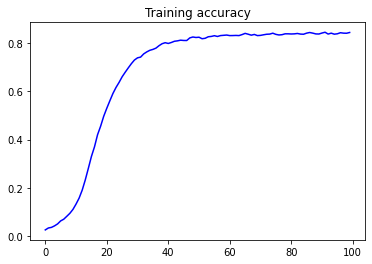

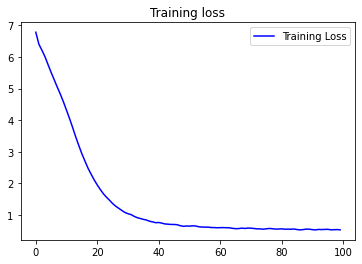

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [11]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope in thee releasing repair bright ' ' ' friend for this verse she be in care the sun light days aside cover away all rolling doubt doubt thee behold i live in heart on thee bring forth forth forth me strange slow you remain remain gone back still dearer ' ' ' told i loved the dumb on high to come too near go wide ' heart it lies not knowing thy proud heart wide wide heart torn torn torn days seen heart away with fullness told not joy the best doth viewest must strive to prove thee doubt '
